## Metric Plots

This notebook loads in the results from the best two models (indep NGB and multivariate Gaussian NGB) then compares them spatially. 
This process creates Figure 3 from the paper

In [1]:
import gc
import os
import sys
import pandas as pd
import numpy as np
from itertools import chain
import pickle
import probdrift
from scipy.stats import multivariate_normal

import probdrift.spatialfns.gpd_functions as gpd_fn
from probdrift.spatialfns import lon_lat_cutter

dfile = "/media/omalley3/Elements/probdrift/drifter_dsets/daily_data_nao_drogue.h5"
sys.path.append("../experiments")
os.environ['data_file'] = dfile

from summarise import read_result, experiment_result, lists_to_mvn
from dispatcher import random_id_subset


drift_data = pd.read_hdf(dfile)
drift_data.reset_index(inplace=True)
drift_data.dropna(inplace=True)
ids = drift_data['id'].values
drift_data[['u', 'v']] = drift_data[['u', 'v']].values*100
N = drift_data.shape[0]
N_fold = 10
# THIS SEED MUST MATCH THE SEED USED IN dispatcher.py
np.random.seed(500)
folds = [random_id_subset(ids, 0.1) for _ in range(N_fold)]
corr_dir = "../experiments/results19may_500/045mvn_ngboost/"
results_corr = read_result(folds, corr_dir)
indep_dir = "../experiments/results19may_500/029indep_ngboost/"
results_indep = read_result(folds, indep_dir)

def results_to_dists(results):
    return [lists_to_mvn(results[0][i], results[1][i]) for i in range(N_fold)]

dists_corr = [dist for list_of_dists in results_to_dists(results_corr) for dist in list_of_dists]
dists_indep = [dist for list_of_dists in results_to_dists(results_indep) for dist in list_of_dists ]

In [2]:
subset_cols = ['lon', 'lat', 'id', 'u','v', 'time']
cov_pars_corr = [probdrift.MVN_helpers.cov_to_sigma(dist.cov) for dist in dists_corr]
corr = [sigma[2] for sigma in cov_pars_corr]

minimal_drift = drift_data[subset_cols]

#This will extract the held out testing $Y$ for each fold, then stack them.
matched = pd.concat([minimal_drift[folds[i][1]] for i in range(N_fold)])
# The seeds for generation of the folds match hence the rows will match up
matched['dists_corr'] = dists_corr
matched['dists_indep'] = dists_indep


gc.collect()

Y = matched[['u', 'v']].values
    
matched['NLL_corr'] = [-dist.logpdf(y) for dist, y in zip(matched['dists_corr'], Y)]
matched['NLL_indep'] = [-dist.logpdf(y) for dist, y in zip(matched['dists_indep'], Y)]
matched['corr']= corr
del cov_pars_corr
del dists_corr
del dists_indep
del drift_data
del Y
gc.collect()
matched.head()

,lon,lat,id,u,v,time,dists_corr,dists_indep,NLL_corr,NLL_indep,corr
8,-40.803001,33.633999,7714456,-5.792063,0.811207,1993-01-01,<scipy.stats._multivariate.multivariate_normal...,<scipy.stats._multivariate.multivariate_normal...,6.919211,7.010683,0.016484
19,-41.846001,26.603001,7708597,5.153558,-0.129893,1993-01-01,<scipy.stats._multivariate.multivariate_normal...,<scipy.stats._multivariate.multivariate_normal...,5.779137,5.704330,-0.021052
35,-40.837002,33.667999,7714456,-3.137195,4.864500,1993-01-02,<scipy.stats._multivariate.multivariate_normal...,<scipy.stats._multivariate.multivariate_normal...,7.226582,7.342861,-0.000860
47,-41.777000,26.593000,7708597,5.330675,-1.689722,1993-01-02,<scipy.stats._multivariate.multivariate_normal...,<scipy.stats._multivariate.multivariate_normal...,5.699180,5.664898,0.018773
60,-41.750999,26.584000,7708597,5.628335,-0.737163,1993-01-03,<scipy.stats._multivariate.multivariate_normal...,<scipy.stats._multivariate.multivariate_normal...,5.776640,5.794161,0.009226


## Record the mean lon and lat velocities of the distribution

In [3]:
matched['mean_lon'] = matched['dists_corr'].apply(lambda x: x.mean[0])
matched['mean_lat'] = matched['dists_corr'].apply(lambda x: x.mean[1])
matched['magnitude'] = np.sqrt(matched['mean_lon'].pow(2)+matched['mean_lon'].pow(2))

## Create $2^{\circ} \times 2^{\circ}$ spatial boxes then summarise within each box

In [4]:
cutter = probdrift.spatialfns.lon_lat_cutter(2)
cutter(matched)
spatial_summaries = matched.groupby(['lon_cut', 'lat_cut'])[["NLL_corr", "NLL_indep",'corr', "lon", 'lat', 'mean_lon', 'mean_lat', 'magnitude']].agg("mean").dropna()
spatial_summaries = spatial_summaries.join(matched.groupby(['lon_cut', 'lat_cut']).size().rename('count'))
## changes the cut indices to a shapely polygon for plotting.
gpd = list(map(probdrift.spatialfns.gpd_functions.cuts2poly,spatial_summaries.index))
spatial_summaries['geometry']=gpd
spatial_summaries['NLL_diff'] = spatial_summaries['NLL_corr']-spatial_summaries['NLL_indep']

## Finally plot relevant columns from spatial_summaries

This forms Figure 3 of the paper or "metrics.png". 

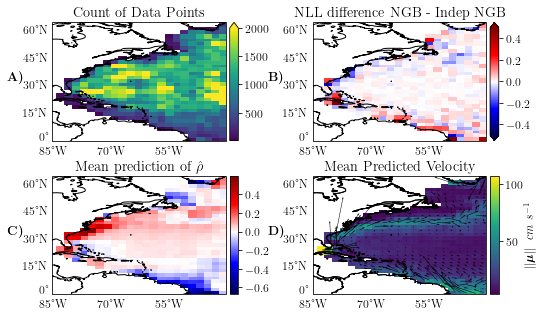

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid1 import make_axes_locatable
import string
from probdrift import mpl_config

plt.rcParams.update(mpl_config)
extent = [-85.01,#summaries['lon'].min(),
          spatial_summaries['lon'].max(),
          -0.01,
          spatial_summaries['lat'].max()
         ]
def add_gridlines(ax, xlocs = [-85, -70, -55, -40],
                      ylocs = list(range(0,66,15))):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray',
                      alpha=0.5, linestyle='--', 
                      
                     )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines=False
    gl.xlocator = mticker.FixedLocator(xlocs)
    gl.ylocator = mticker.FixedLocator(ylocs)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
def plot_column(daf, column, ax, cmap='viridis', vmin_manual=None, vmax_manual=None):
    vmin, vmax =daf[column].min(), daf[column].max()
    changed_vmin, changed_vmax = False, False
    if vmin_manual is not None:
        changed_vmin = vmin!=vmin_manual
        vmin = vmin_manual
    if vmax_manual is not None:
        changed_vmax = vmax!=vmax_manual
        vmax = vmax_manual
        #norm = mpl.colors.LogNorm(vmin=daf[column].min(), vmax=daf[column].max())
    extend="neither"
    if changed_vmin:
        if changed_vmax:
            extend="both"
        else:
            extend="min"
    else:
        if changed_vmax:
            extend="max"
        
    
    if cmap == 'seismic':
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0,vmax=vmax)
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    f = ax.get_figure()
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                   extend=extend)
    f.add_axes(cax)
    crs = ccrs.PlateCarree()
    for color, rows in daf.groupby(column):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(
            rows["geometry"], crs=crs, facecolor=color_mapped, edgecolor=color_mapped
        )
    return cax



metric_names = ['count', 'NLL_diff', 'corr', 'magnitude']#, 'coverage Indep', 'coverage', 'area', 'NLL_det', 'count']
cbar_names = ["", "", "", "$||\\boldsymbol{\mu}||~~ cm~s^{-1}$", "", "", "", ""]
titles = ['Count of Data Points',
          'NLL difference NGB - Indep NGB',
          'Mean prediction of $\\hat{\\rho}$',
          'Mean Predicted Velocity',
         ]
cbar_ranges = [[None,None]]*6
cbar_ranges[1] = [-0.5,0.5]
cbar_ranges[0] = [None, 2000]
cmaps = ['viridis']*8
cmaps[2] = 'seismic'
cmaps[1] = 'seismic'


fig, axs = plt.subplots(2,2,figsize=(8,5), subplot_kw= {"projection":ccrs.PlateCarree()})
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[row,col]
    cbar_range = cbar_ranges[i]
    cax = plot_column(spatial_summaries,
                      metric,
                      ax=current_ax, 
                      cmap = cmaps[i],
                      vmin_manual=cbar_range[0],
                      vmax_manual=cbar_range[1])
    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[i], labelpad=0.1)
    
def add_letters(axs):
    for n, ax in enumerate(axs.flatten()):
        ax.text(-0.26, 0.5, "\\textbf{"+ string.ascii_uppercase[n]+")}", transform=ax.transAxes, 
            size=13, weight='bold')
add_letters(axs)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
axs[1,1].quiver(spatial_summaries['lon'], spatial_summaries['lat'], spatial_summaries['mean_lon'], spatial_summaries['mean_lat'], zorder=15)
axs[1,1].coastlines()
axs[1,1].set_aspect('auto')
axs[1,1].set_title("Mean Predicted Velocity")
#fig.tight_layout()
fig.savefig("../Images/metrics.png",bbox_inches='tight', dpi=600)

# Is there a pattern to where NGB is doing better?

In [6]:
# lon_range = [-81, -76]
# lat_range = [27,33]
#The analysis results in 9.46, 9.52 for the following two points
lon_range = [-80.0001, -73.9999]
lat_range = [30.9999,35.0001]
mask = np.logical_and(
matched["lon"].between(*lon_range),
matched["lat"].between(*lat_range)
)
subset_gulfstream = matched[mask].copy()

In [7]:
print(subset_gulfstream["NLL_corr"].mean())
print(subset_gulfstream["NLL_indep"].mean())

9.464510786432962
9.519192134462154


In [8]:
subset_gulfstream.shape
subset_gulfstream.sem()

lon               0.021321
lat               0.014212
id           353248.878901
u                 0.603806
v                 0.609025
NLL_corr          0.026490
NLL_indep         0.026060
corr              0.003176
mean_lon          0.394082
mean_lat          0.417811
magnitude         0.446504
dtype: float64

In [9]:
cutter = probdrift.spatialfns.lon_lat_cutter(0.5)
cutter(subset_gulfstream)
gulfstream_spatial_summaries = subset_gulfstream.groupby(['lon_cut', 'lat_cut'])[["NLL_corr", "NLL_indep",'corr', "lon", 'lat', 'mean_lon', 'mean_lat', 'magnitude']].agg("mean").dropna()
## changes the cut indices to a shapely polygon for plotting.
gpd = list(map(probdrift.spatialfns.gpd_functions.cuts2poly,gulfstream_spatial_summaries.index))
gulfstream_spatial_summaries = gulfstream_spatial_summaries.join(subset_gulfstream.groupby(['lon_cut', 'lat_cut']).size().rename('count'))
gulfstream_spatial_summaries['geometry']=gpd
gulfstream_spatial_summaries['NLL_diff'] = gulfstream_spatial_summaries['NLL_corr']-gulfstream_spatial_summaries['NLL_indep']

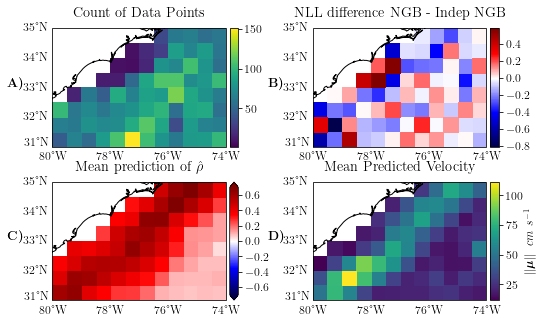

In [10]:
extent = lon_range+lat_range
fig, axs = plt.subplots(2,2,figsize=(8,5), subplot_kw= {"projection":ccrs.PlateCarree()})
cbar_ranges = [[None,None]]*4
cbar_ranges[2] = [-0.7, 0.7]
cmaps = ['viridis']*8
cmaps[2] = 'seismic'
cmaps[1] = 'seismic'
for i, metric in enumerate(metric_names):
    col = int(i%2)
    row = int((i-col)/2)
    current_ax = axs[row,col]
    cbar_range = cbar_ranges[i]
    cax = plot_column(gulfstream_spatial_summaries,
                      metric,
                      ax=current_ax, 
                      cmap = cmaps[i],
                      vmin_manual=cbar_range[0],
                      vmax_manual=cbar_range[1])

    current_ax.set_title(titles[i])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(
        current_ax, 
                  xlocs=list(range(round(lon_range[0]), round(lon_range[1])+1,2)), 
                  ylocs = list(range(round(lat_range[0]), round(lat_range[1])+ 1))
                 )
    cax.set_ylabel(cbar_names[i], labelpad=0.1)

add_letters(axs)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig("../Images/gulfstream_metrics.png" ,bbox_inches='tight', dpi=600)

In [11]:
list(range(round(lon_range[0]), round(lon_range[1])+1,1))

[-80, -79, -78, -77, -76, -75, -74]

# How long does it take a drifter to travel 1,000 km in a calmer section of ocean

We'll consider drifter 122571

In [12]:
long_trajectory = matched.query("id==122571")

In [13]:
long_trajectory[["NLL_corr", "NLL_indep"]].mean()

NLL_corr     7.560769
NLL_indep    7.556326
dtype: float64

In [14]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

lon = long_trajectory["lon"].to_numpy()
lat = long_trajectory["lat"].to_numpy()
x = [haversine_np(lon[i], lat[i], lon[i+1], lat[i+1]) for i in range(300)]

np.argmin(np.cumsum(x)<1073)

112